# Question-: 2.a)

In [1]:
#Imports the all the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import random
from random import seed
from random import randrange
from csv import reader

In [3]:
# Obtains the accuracy matrix
def predictaccuracy(actual, predicted):
    success= 0  # number of predication that has been done correctly
    failure = 0 # number of prediction that has been done incorrectly
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            success += 1
        else:
            failure += 1
    return true_tag / float(len(actual)) * 100.0

# Question : 2.b)This algorithm splits the data into training and test data at 70 and 30% each.

In [4]:
# Evaluate the algorithm using a cross validation split
def splittingalgo(dataset, algorithm, n_folds, *args):
    #split the data in k folds
    #The number of folds should be passed as a parameter when calling the function.
    data = dataset
    dataset_split = list()  #list to store all the k folds 
    dataset_copy = list(data)
    train_size = ((len(data)*70)/100)  #size of the training data
    test_size  = ((len(data)*30)/100)  #size of the test data
    for i in range(0,2):
        fold = list()
        while len(fold) < train_size and i==0:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        if i==1:
            fold=dataset_copy
        dataset_split.append(fold)
    scores = list()
    train_set = dataset_split[0]
    test_set = dataset_split[1]
    predicted = algorithm(train_set, test_set, *args)
    actual = [row[-1] for row in fold]
    accuracy = predict(actual, predicted)
    scores.append(accuracy)
    return scores

In [5]:
#  Computes using a cross validation split via regression
def regalgo(dataset, algorithm, n_folds, *args):
    #split the data in k folds
    data = dataset
    n = n_folds
    dataset_split = list()  #list to store all the k folds 
    dataset_copy = list(data) 
    fold_size = int(len(data) / n)  #size of each fold
    for i in range(0,n):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    folds = dataset_split

    scores = list()   
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)  
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = predictaccuracy(actual, predicted)
        scores.append(accuracy)
    return scores

# K fold Algorithm

In [6]:
# Evaluates the kfoldalgorithm using a cross validation split
def kfoldalgo(dataset, algorithm, n_folds, *args):
    #Splits the data into k folds
    data = dataset
    n = n_folds
    dataset_split = list()  #list to store all the k folds 
    dataset_copy = list(data) 
    fold_size = int(len(data) / n)  #size of each fold
    for i in range(0,n):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    folds = dataset_split

    scores = list()   
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)  
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = predictaccuracy(actual, predicted)
        scores.append(accuracy)
    return scores

In [7]:
# Splits a dataset based on an attribute and it's  value
def datasetsplit(index, value, dataset):
    leftmost, rightmost = list(), list()
    for row in dataset:
        if row[index] < value:
            leftmost.append(row)
        else:
            rightmost.append(row)
    return leftmost, rightmost

# Calculates the Gini index for a split dataset
def extractginiindex(groups, classes):
    #Gini index is calculated in case of ambuiguity arised due to considering multiple attributes
    # Counts all the samples at split point
    n = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n)
    return gini

# Select the best split point for a dataset
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = datasetsplit(index, row[index], dataset)
            gini = extractginiindex(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

# Creates the terminal nodes value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

# Create child splits for a particular node or makes terminals
def split(node, max_depth, min_size, depth):
    leftmost, rightmost = node['groups']
    del(node['groups'])
    # check for a no split
    if not leftmost or not rightmost:
        node['left'] = node['right'] = to_terminal(leftmost + rightmost)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(leftmost), to_terminal(rightmost)
        return
    # process left child
    if len(leftmost) <= min_size:
        node['left'] = to_terminal(leftmost)
    else:
        node['left'] = get_split(leftmost)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(rightmost) <= min_size:
        node['right'] = to_terminal(rightmost)
    else:
        node['right'] = get_split(rightmost)
        split(node['right'], max_depth, min_size, depth+1)

# Makes a prediction using a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Classification and Regression Tree Algorithm
def cart(train, test, max_depth, min_size):
    root = get_split(train)                            #assigning the root node in the tree
    split(root, max_depth, min_size, 1)
    tree = root
    predictions = list()
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return(predictions)

# Ans 2(b) model for 70-30 using depth 7 and leaf size 11

In [8]:
# Calls the above functions
filename = 'C:\\Users\\SREEJITH\\Desktop\\iris.csv'
file = open(filename, "rt")  # opening the csv file
li = reader(file)
dataset = list(li)
n = 1
max_depth = 7
min_size = 11
#print(len(list(dataset)))
scores = algorithm_70_30(dataset, cart, n, max_depth, min_size)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [88.88888888888889]
Mean Accuracy: 88.889%


# ANS 2(c)  Hyperparameter tuning 

In [9]:
# main method in the code
filename = 'C:\\Users\\SREEJITH\\Desktop\\iris.csv'
file = open(filename, "rt")  # opening the csv file
li = reader(file)
dataset = list(li)
x = list()
n = 4
min_size = 8
max_acc = 0
optimal_depth = 0
k = list(range(2,20))
p = 0
for l in range(2,20):
    min_size = l
    for depth in range(2,20):
        max_depth = depth
        scores = kfoldalgo(dataset, cart, n, max_depth, min_size)
        x.append((sum(scores)/float(len(scores))))
        if(max_acc < (sum(scores)/float(len(scores)))):
            max_acc = (sum(scores)/float(len(scores)))
            optimal_depth = max_depth
            p = l
print("maximum accuracy",max_acc," is at depth",optimal_depth,"with leaf size ",p)

maximum accuracy 95.94594594594595  is at depth 19 with leaf size  11


# During 5-fold cross validation we are getting the maximum accuracy (95.94%) at depth 19 and leaf size 11. So we will train our model for depth = 19 and leaf size 11

# Ans - 3 Decision tree for regression using real state data

In [8]:
# main method in the code
filename = 'C:\\Users\\SREEJITH\\Desktop\\real_state.csv'
file = open(filename, "rt")  # opening the csv file
li = reader(file)
dataset = list(li)
n = 2
max_depth = 7
min_size = 11
#print(dataset)
scores = regalgo(dataset, cart, n, max_depth, min_size)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [0.4830917874396135, 0.0]
Mean Accuracy: 0.242%


# As we are using classification over a regression problem so we are getting a very bad accuracy(0.242%). We have to calculate either mean absolute error or mean squre error for the regression problem.

In [10]:
# Decision tree using scikitlearn over real estate price prediction problem
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
#imports numpy as np
# Fits the regression model
clf1 = DecisionTreeRegressor(max_depth=2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
iris = pd.read_csv('real_state.csv')
print("max:",max(iris['Y house price of unit area']))
print("min:",min(iris['Y house price of unit area']))
d = iris.drop("Y house price of unit area" ,axis=1)
x_train1, x_test1, y_train1, y_test1 = train_test_split(d,iris['Y house price of unit area'] , test_size=0.3)
clf1 = clf1.fit(x_train1,y_train1)
prediction = clf1.predict(x_test1)
acc = mean_squared_error(y_test1, prediction,  sample_weight=None)
print("Mean squared error over the regression:",acc)

max: 117.5
min: 7.6
Mean squared error over the regression: 54.22627091487931


# Ans -4 Decision tree using sklearn

In [13]:
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
iris = pd.read_csv('iris2.csv')
d = iris.drop("species" ,axis=1)
x_train, x_test, y_train, y_test = train_test_split(d,iris['species'] , test_size=0.3)
#searches for 'species' in the iris dataset
clf = tree.DecisionTreeClassifier(max_depth = 7,min_samples_leaf=11)
clf = clf.fit(x_train,y_train)
prediction = clf.predict(x_test)
acc = accuracy_score(y_test, prediction, normalize=True, sample_weight=None)
print(acc*100)

95.55555555555556


# My model generated an accuracy of 95.94 at a depth of 17 and a leaf size of 6, Whereas Scikit learn had an accuracy of 95.55 when tested at a depth of 7 , with minimum samples leaf as 11. Thus my model had an improvement of 0.40%

# Ans 5 -> Visualization of the decision tree of the scikit learn over iris dataset.

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


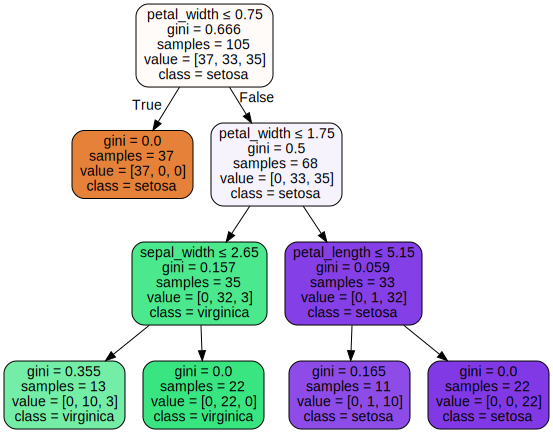

In [14]:
import graphviz 
from sklearn import tree
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris.csv")
print(list(x_train))
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=list(x_train),  
                      class_names=list(y_train),  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

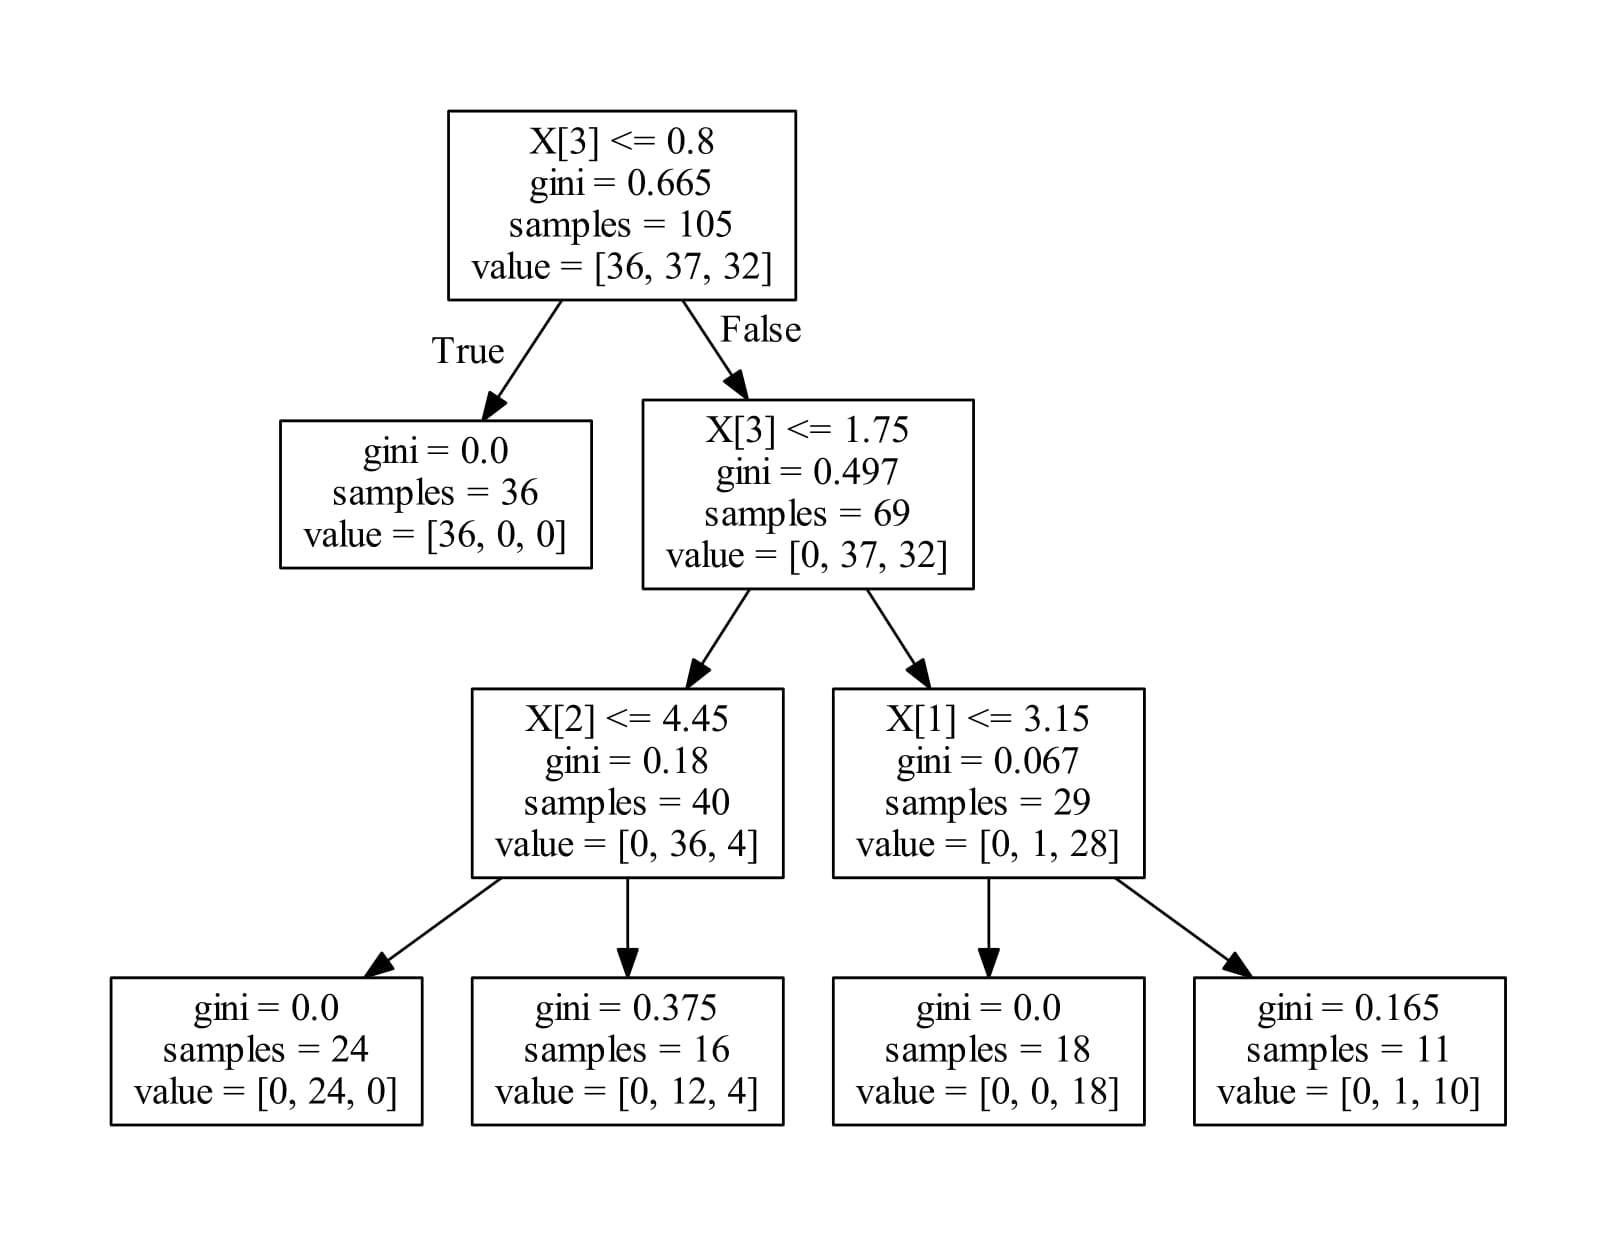

# We can see that the depth is 3 and the gini index has reached 0 on 3 ocassions

['No', 'X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']


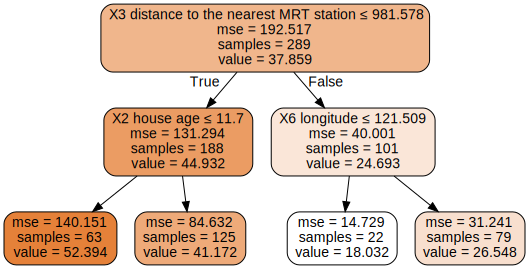

In [15]:
import graphviz 
dot_data = tree.export_graphviz(clf1, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("real_estate")
print(list(x_train1))
dot_data = tree.export_graphviz(clf1, out_file=None, 
                      feature_names=list(x_train1),  
                      class_names=list(y_train1),  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

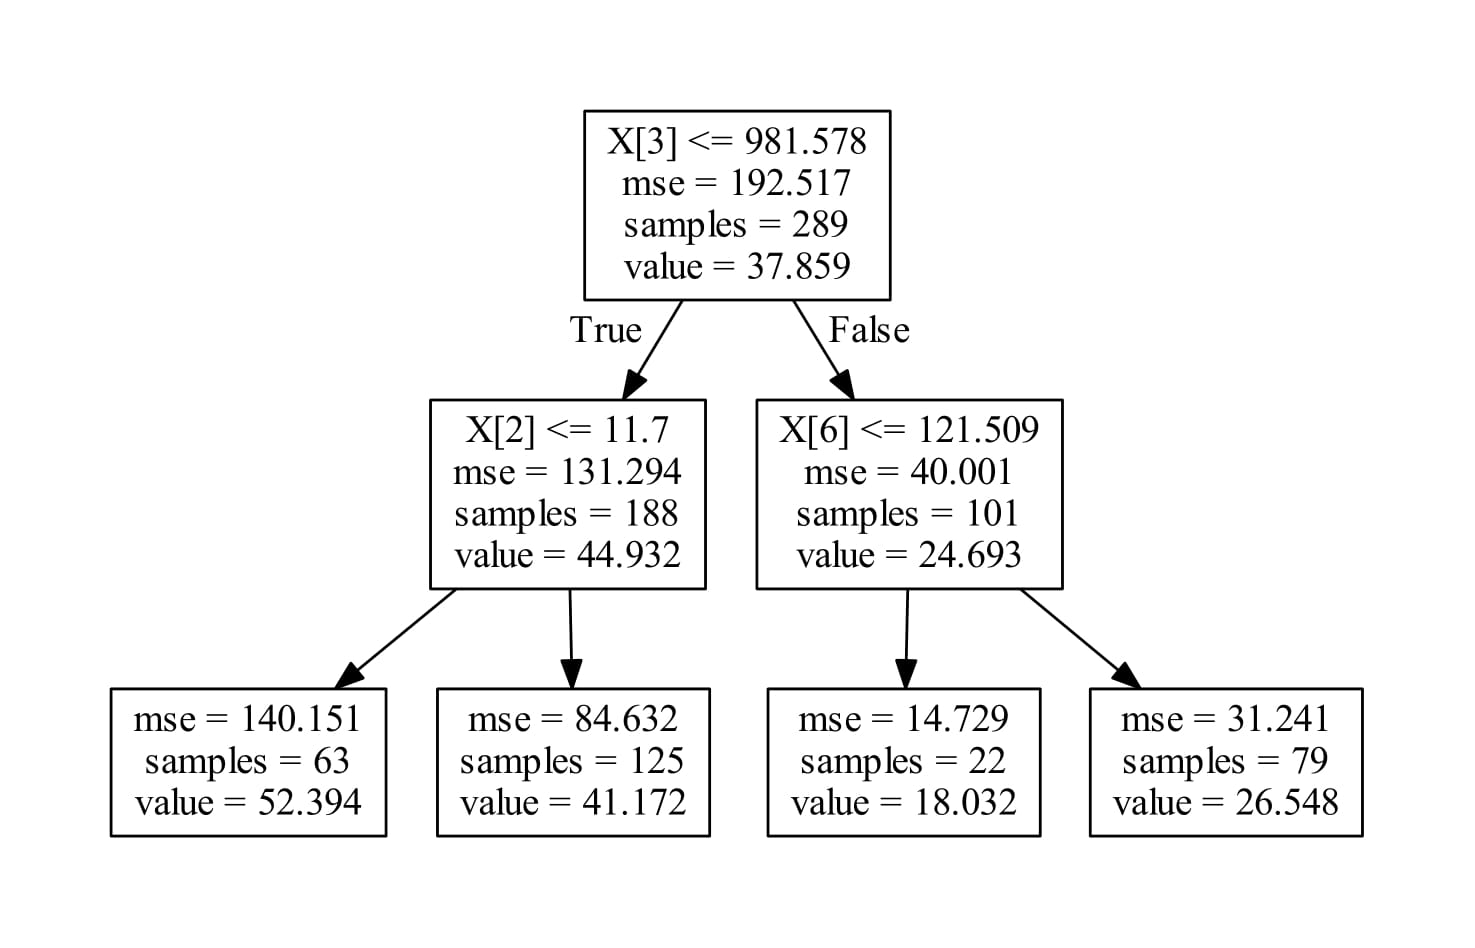

# Depth is 2 

# Question 6 :

In [28]:
from csv import reader
filename = 'C:\\Users\\SREEJITH\\Desktop\\iris.csv'
file = open(filename, "rt")  # Opens the csv file
li = reader(file)
dataset = list(li)

In [29]:
#Divides the dataset into training set  and test set  
from random import randrange
data = dataset
dataset_split = list()  #list to store all the k folds 
dataset_copy = list(data)
train_size = ((len(data)*70)/100)  #size of the training data
test_size  = ((len(data)*30)/100)  #size of the test data
#print(len(dataset_copy))
for i in range(0,2):
    fold = list()
    while len(fold) < train_size and i==0:
        index = randrange(len(dataset_copy))
        fold.append(dataset_copy.pop(index))
    if i==1:
        fold=dataset_copy
    dataset_split.append(fold)
train_data = dataset_split[0]
test_data  = dataset_split[1]

In [30]:
#Code to find out the training error(for training set) for iris dataset
def algorithm_training(dataset, algorithm, n_folds, *args):   
        train_set = list(dataset)  
        test_set = list(dataset)
        predicted = algorithm(train_set, train_set, *args)
        actual = [row[-1] for row in train_set]
        accuracy = predictaccuracy(actual, predicted)
        #scores.append(accuracy)
        return accuracy

In [31]:
max_acc = 0
min_acc = 100
worst_depth = 0
for depth in range(2,15):
        max_depth = depth
        scores = algorithm_training(train_data, decision_tree, n_folds, max_depth, min_size)
        if(max_acc < scores):
            max_acc = scores
            optimal_depth = max_depth
        if(min_acc >scores):
            min_acc = scores
            worst_depth = max_depth
print("worst and best accuracy on the training set")
print("max accuracy:",max_acc,"optimal depth:",optimal_depth)
print("min accuracy:",min_acc,"worst depth:",worst_depth)

worst and best accuracy on the training set
max accuracy: 95.28301886792453 optimal depth: 3
min accuracy: 94.33962264150944 worst depth: 2


# Thus we notice that the optimal depth is 3 and the worst depth is 2. The corresponding accuracies are 95.28(Max) and 94.33(Min)